In [1]:
# Initialize Libraries and Dependencies

# Data handling and manipulation
import pandas as pd
pd.options.display.max_rows = 150

import numpy as np

# path to file directory holding csv
from pathlib import Path

import seaborn as sns
import hvplot.pandas

# Package that identifies the most probable distributions and their best parameters.
from fitter import Fitter, get_common_distributions

# XGBoost
# This doesnt plot very well with matplotlib
import xgboost as xg

# Machine Learning from Scikit-learn
# LinearRegression
from sklearn.linear_model import LinearRegression
# Generating the Feature Sets
from sklearn.model_selection import train_test_split
# Relevant Metrics
from sklearn.metrics import mean_squared_error, r2_score, classification_report, accuracy_score

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Import the PCA module
from sklearn.decomposition import PCA

# Redact warnings
import warnings
warnings.filterwarnings("ignore")


# Visualization
import matplotlib.pyplot as plt
%matplotlib inline 

### 1. Consider data set 1 (ds1.csv). The data set comprises features (the Five xs) along with three sequences that may or may not be generated from the features (3 ys).

### a. Describe the data set in a few sentences.
- What are the distributions of each feature? 
- Summary statistics?

### Read in data

In [38]:
# Set the path to the 'ds1.csv' and 'ds2.csv' file
csv_path1 = Path('./Resources/ds1.csv')
csv_path2 = Path('./Resources/ds2.csv')

In [39]:
# Use the file path to read the CSV into a DataFrame and display a few rows
# drop "Unnamed:0" column from both datasets

ds1_df = pd.read_csv(csv_path1)
ds2_df = pd.read_csv(csv_path2)

display(ds1_df.head())
# display(ds2_df.head())

Unnamed: 0        x1        x2        x3        x5        x6         ya  \
0           1  2.642583 -1.715220  1.909334  0.027139 -3.447187  13.630850   
1           2  4.588761 -2.507543  4.239107  1.704150 -2.782809   7.834582   
2           3  7.919796 -5.108415  3.039451  0.992815  5.551587  -5.107041   
3           4  2.616757 -2.124040  2.855570  0.990079  1.694697  19.015046   
4           5  3.300856 -5.159684  0.764544  0.143581  3.277496  -9.818862   

         yb        yc  
0  1.828765  0.008386  
1  2.162110  0.000008  
2  2.797083 -0.000005  
3  1.953887  0.038017  
4  1.922446  0.001178

### Clean Data

In [40]:
# Drop the un needed extra index column from the data using the drop() function. 
# Specify the columns to be dropped using the columns[] function 
# in this instance we are referring to col 0 as it is the first column
ds1_df = ds1_df.drop(ds1_df.columns[0], axis=1)
ds2_df = ds2_df.drop(ds2_df.columns[0], axis=1)

# Check for missing data using isna() function
# use the sum() function to count the amount of missing data
print("Null count for ds1")
display(ds1_df.isna().sum())
# print()
# print("Null count for ds2")
# display(ds2_df.isna().sum())

Null count for ds1


x1    0
x2    0
x3    0
x5    0
x6    0
ya    0
yb    0
yc    0
dtype: int64

### Summary Statistics

### Give a descriptive summary of all features included in the datasets statistics using the describe() function
The statistics included in this function are:
- Null Count
- Mean
- Standard Deviation (STD)
- min/max
- 25/50/75 percentiles

Since we will be applying the Pandas describe() function to a dataframe, the result is also returned as a dataframe. 

In [41]:
# Generate a descriptive statistic summary for the dataset using the describe() function
ds1_df.describe()

x1             x2             x3             x5  \
count  100000.000000  100000.000000  100000.000000  100000.000000   
mean        5.011059      -3.005565       2.500593       0.999136   
std         2.873568       2.000799       1.752906       1.002006   
min         0.000015     -12.498524      -3.489212       0.000003   
25%         2.536309      -4.353844       1.189920       0.285629   
50%         5.022191      -3.002649       2.503764       0.690903   
75%         7.486275      -1.649283       3.802236       1.386862   
max         9.999887       6.089820       8.679097      15.102966   

                  x6             ya             yb            yc  
count  100000.000000  100000.000000  100000.000000  1.000000e+05  
mean        0.000647       3.827867       2.111854  1.022765e-04  
std         4.663860      18.438514       0.769306  3.121215e-02  
min       -13.885453     -64.021995      -0.523672 -5.433613e-01  
25%        -2.611943      -8.998020       1.580212 -2.423159e-03  
50%        -0.000611       2.666992       2.231057 -5.670000e-10  
75%         2.621841      15.579687       2.733318  2.476745e-03  
max        13.924740     107.713997       3.841363  8.183882e-01

### Visual Depiction of Distributions for each feature

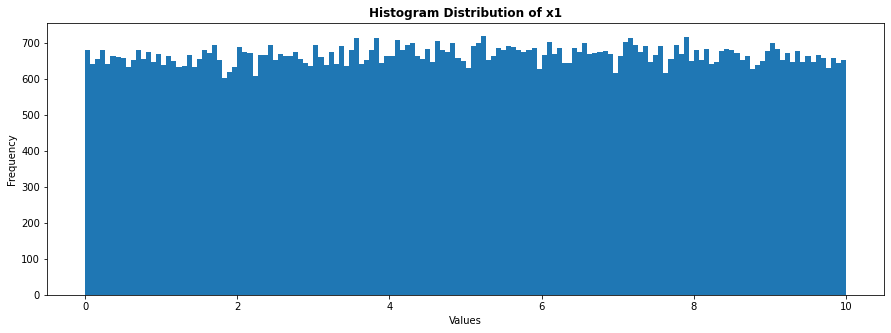

Fitting 10 distributions: 100%|██████████| 10/10 [00:05<00:00,  1.69it/s]


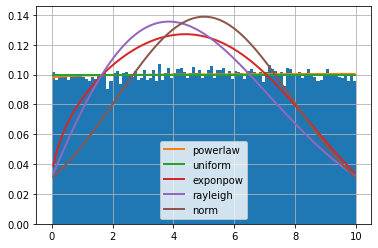

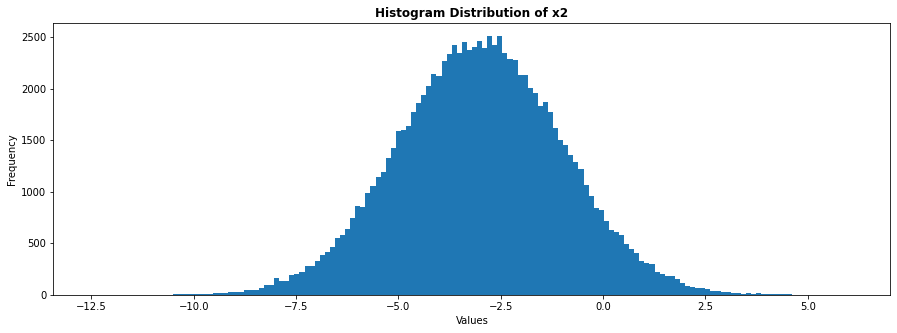

Fitting 10 distributions: 100%|██████████| 10/10 [00:05<00:00,  1.67it/s]


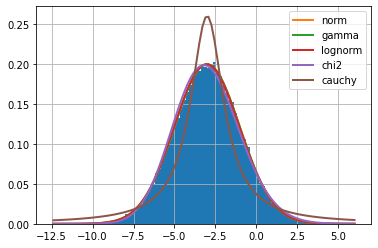

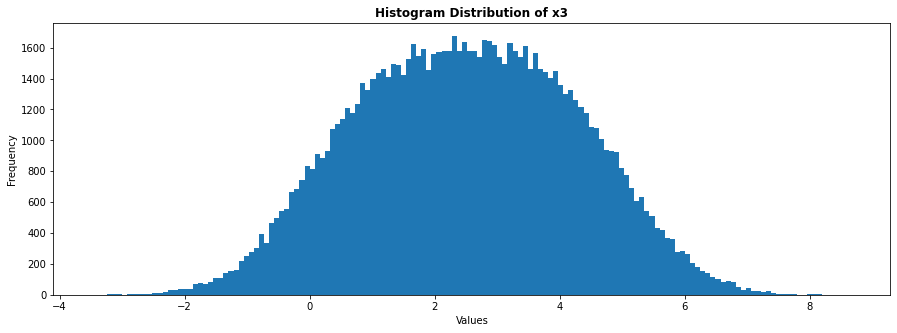

Fitting 10 distributions: 100%|██████████| 10/10 [00:06<00:00,  1.61it/s]


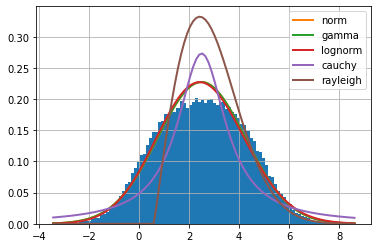

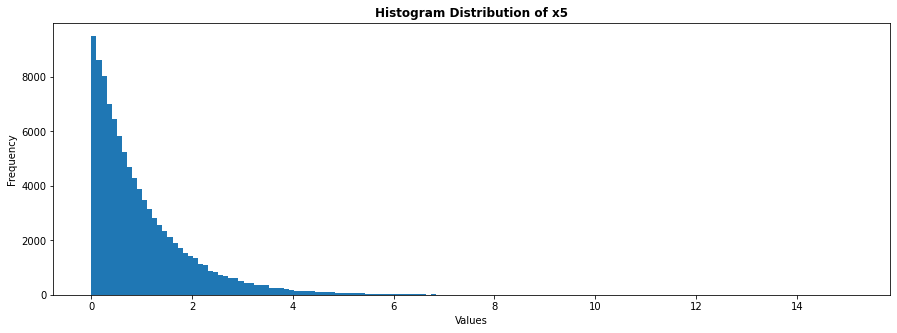

Fitting 10 distributions: 100%|██████████| 10/10 [00:06<00:00,  1.60it/s]


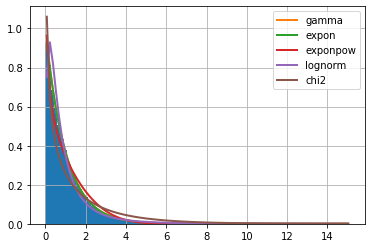

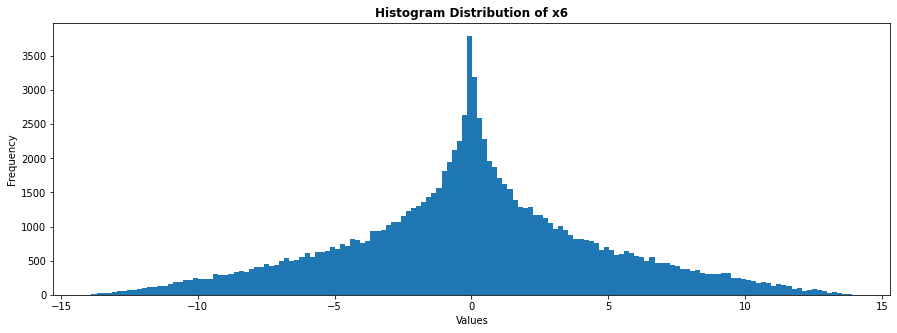

Fitting 10 distributions: 100%|██████████| 10/10 [00:04<00:00,  2.02it/s]


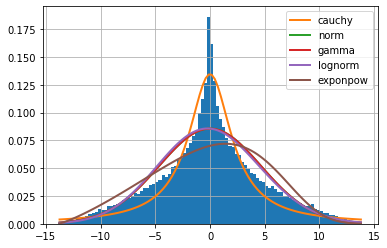

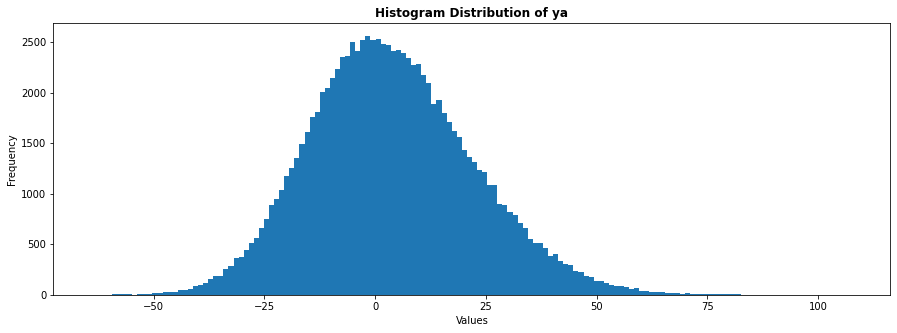

Fitting 10 distributions: 100%|██████████| 10/10 [00:06<00:00,  1.63it/s]


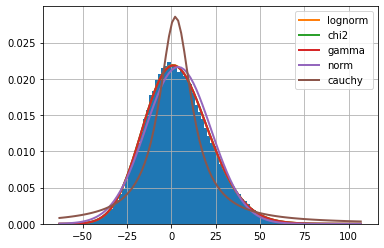

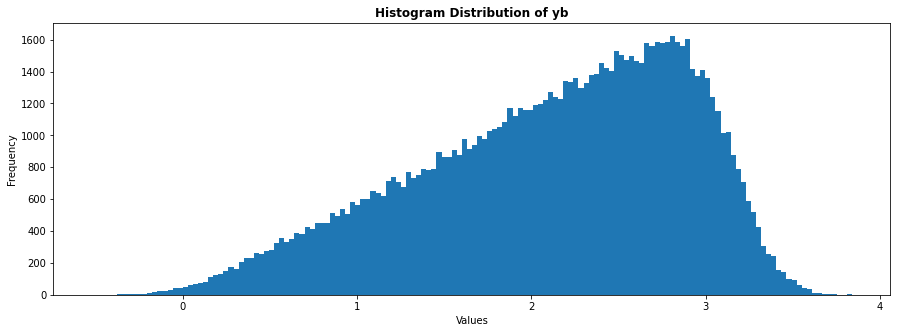

Fitting 10 distributions: 100%|██████████| 10/10 [00:04<00:00,  2.17it/s]


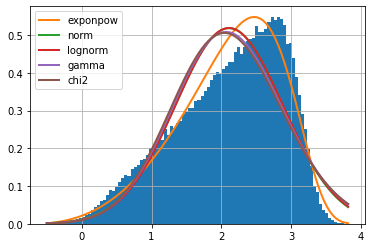

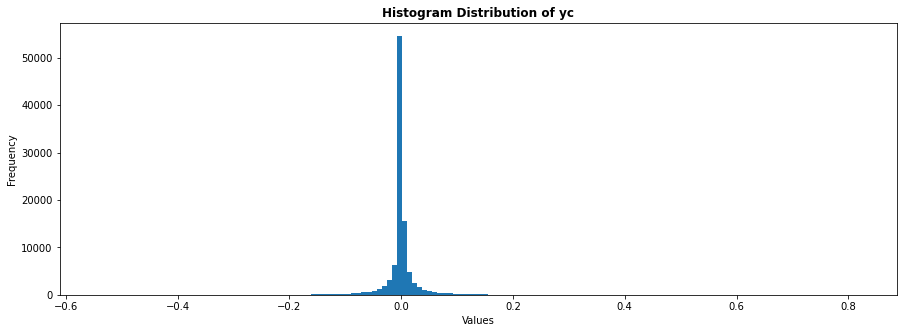

Fitting 10 distributions: 100%|██████████| 10/10 [00:04<00:00,  2.39it/s]


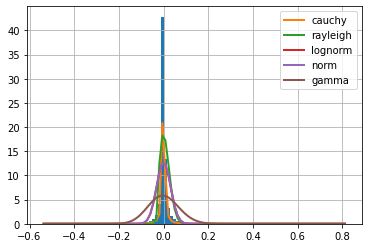

In [42]:
# Create a custom function that will plot the optimal histogram distribution for each feature in the dataset

def OptimalHistogramDistribution(df, col):
    # Plot a histogram for each isolated feature
    fig, axs = plt.subplots(figsize=(15,5))
    plt.hist(df[col], bins=150)
    plt.title(f'Histogram Distribution of {col}', fontweight = 'bold')
    plt.ylabel('Frequency')
    plt.xlabel('Values')
    plt.show()
    # Use fitter() function to find the optimal histogram distribution for each isolated feature
    # Use the get_common_distributions() function to use the top 10 most common histogram distributions
    # The function will only plot the top 5 distributions for each dataset to eliminate redundent noise. 
    # Model
    f = Fitter(df[col], distributions = get_common_distributions())
    # Fit
    f.fit()
    # Predict
    f.summary()    
    f.get_best(method='sumsquare_error')
    
# Create a for loop that iterates through all of the features in the dataset
#  and uses our funtion to find and visualizes the best histogram distributions
for feature in ds1_df:
    OptimalHistogramDistribution(ds1_df, feature)

## What are the distributions of each feature?

x1 - Uniform Distribution (Equal spread, no peaks)

x2 - Normal Distribution (Unimodal, symmetric, "Bell Curve")

x3 - Normal Distribution (Unimodal, symmetric, "Bell Curve")

x5 - Right Skewed Distribution (Positively-skewed)

x6 - Normal Distribution (Unimodal, symmetric, "Bell Curve", wide range)

--- 

### Sequences Distributions
ya - Normal Distribution (Unimodal, symmetric, "Bell Curve")

yb - Left Skewed Distribution (Negatively-skewed)

yc - Uniform Distribution (Equal spread, no peaks, narrow range)


### b. Try to come up with a predictive model, e.g. y = f(x_1 , … , x_n) for each y sequence. 
- Describe your models and how you came up with them. 
- What (if any) are the predictive variables? 
- How good would you say each of your models is?

The metrics for evaluating the Linear Regression model:

    1. R Square - Value is between 0 to 1 and a bigger value indicates a better fit between prediction and actual value.

    2. Mean Square Error(MSE) - It gives you an absolute number on how much your predicted results deviate from the actual number. You cannot interpret many insights from one single result but it gives you a real number to compare against other model results and help you select the best regression model.

    3. Root Mean Square Error(RMSE) - Most popular metric, the result is square rooted to make it more interpretable as it’s in base units. It is recommended that RMSE be used as the primary metric to interpret the model.


### Internalize the correlation of the 3 Sequences


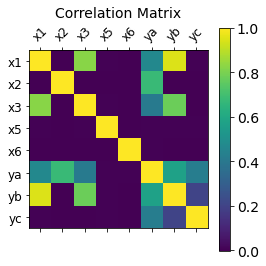

In [43]:
# Create a Correlaion Matrix of the features and sequences in the dataset

# Use corr() function to find the correlation among the columns in the Dataframe using the ‘Pearson’ method,
# this method ignores non-numerical columns
plt.matshow(ds1_df.corr())

# Add axis labels to match the dataframe
# select_dtypes(['number']) should be used when defining the labels to avoid an unwanted shift of the labels
plt.xticks(range(ds1_df.select_dtypes(['number']).shape[1]), ds1_df.select_dtypes(['number']).columns, fontsize=12, rotation=45)
plt.yticks(range(ds1_df.select_dtypes(['number']).shape[1]), ds1_df.select_dtypes(['number']).columns, fontsize=12)

# Add a colorbar legend to interpret the color scale.
colorbar = plt.colorbar()
colorbar.ax.tick_params(labelsize=14)

# Add a title to the Plot
plt.title('Correlation Matrix', fontsize=14);

# Save fig to Images folder
plt.savefig('./Images/ds1_df_correlation_matrix.png')

Sequence 'yc' doesn't seem to be correlated with any of the features.
The Sequences correlate to one another, debunking the question if they are generated from features.

### Machine Learning

### Prepare the data for the models

In [44]:
# Prepare the data for the models

#define the dependent and independent relationships
features = ds1_df[['x1','x2','x3','x5','x6']]
ya = ds1_df['ya']
yb = ds1_df['yb']
yc = ds1_df['yc']

# Create a variable 'X' that holds all the independent variables 
X = features

# Display sample data
display(X[:5])

# Use the shape() function to determine the sample size and quantity of features
# The shape of X is 100000 samples, with 5 features (columns)
print('How much data is in the dataset')
display(X.shape)

x1        x2        x3        x5        x6
0  2.642583 -1.715220  1.909334  0.027139 -3.447187
1  4.588761 -2.507543  4.239107  1.704150 -2.782809
2  7.919796 -5.108415  3.039451  0.992815  5.551587
3  2.616757 -2.124040  2.855570  0.990079  1.694697
4  3.300856 -5.159684  0.764544  0.143581  3.277496

How much data is in the dataset


(100000, 5)

### Build the XGBoost Model

In [45]:
def XGBoost_model(X,y):
    # convert the dataset into an optimized data structure called Dmatrix using the DMatrix() function
    # XGBoost supports this structure and gives it acclaimed performance and efficiency gains.
    data_dmatrix = xg.DMatrix(data=X,label=y)
    # Using the train_test_split() function, split the dataset and train 80%
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1)
    # Instantiation of the XBBoost Regressor model by calling the XGBRegressor() function
    xgb_r = xg.XGBRegressor(objective ='reg:squarederror',
                      n_estimators = 10, seed = 123)
    # Fit the regressor model to the training set using the fit() method
    xgb_r.fit(X_train, y_train)
    # Predict the model of the test set using the predict() method
    pred = xgb_r.predict(X_test)
    # Use a k-fold cross validation to build a more robust model
    # create a hyper-parameter dictionary 'params' which holds all the hyper-parameters and their values as key-values
    params = {"objective":"reg:squarederror",'colsample_bytree': 0.3,'learning_rate': 0.1,
                    'max_depth': 5, 'alpha': 10}
    # use these parameters to build a 3-fold cross validation model by invoking XGBoost's cv() method
    # store the results in a cv_results DataFrame 
    # *Note that the Dmatrix object is being used
    cv_results = xg.cv(dtrain=data_dmatrix, params=params, nfold=3,
                        num_boost_round=50,early_stopping_rounds=10,metrics="rmse", as_pandas=True, seed=123)
    # cv_results contains train and test RMSE metrics for each boosting round.
    cv_results.head()
    print((cv_results["test-rmse-mean"]).tail(1))
    # Force matplotlib, plots render weird otherwise
    import matplotlib.pyplot as plt
    %matplotlib inline
    # Visualize feature importance using the plot_importance() method
    xg.plot_importance(xgb_r)
    plt.show()
    # Visualize the Boosting Tree using the plot_tree() function
    # pass the num_trees arguement to choose amount of trees
    xg_reg = xg.train(params=params, dtrain=data_dmatrix, num_boost_round=10)
    xg.plot_tree(xg_reg,num_trees=0)
    plt.rcParams['figure.figsize'] = [50, 10]
    plt.show()

### XGBoost Model Assessment

49    11.495742
Name: test-rmse-mean, dtype: float64


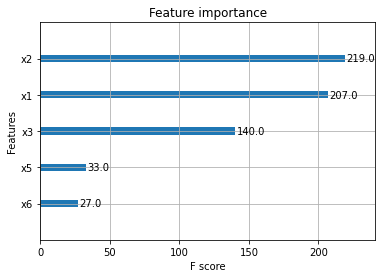

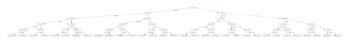

In [46]:
# Test sequence ya with the XGBoost Model
XGBoost_model(X,ya)

49    0.280711
Name: test-rmse-mean, dtype: float64


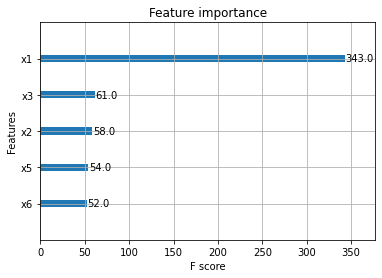

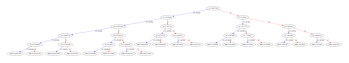

In [47]:
# Test sequence yb with the XGBoost Model
XGBoost_model(X,yb)

49    0.031332
Name: test-rmse-mean, dtype: float64


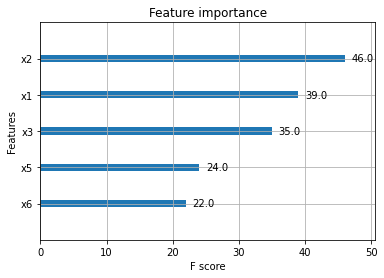

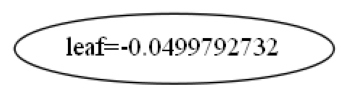

In [48]:
# Test sequence yc with the XGBoost Model
XGBoost_model(X,yc)

In [49]:
# Re introduce matplot lib after running xgboost to override the glitches
# these libraries do not play very nicely together
import matplotlib.pyplot as plt
%matplotlib inline

### Build the Linear Regression Model

In [50]:
def linear_regression_model(X,y):
    # Using the train_test_split() function, split the dataset and train 80%
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1)
    # Create a model with scikit-learn using the LinearRegression() function
    model = LinearRegression()
    # Fit the data into the model
    model.fit(X_train,y_train)
    # Display the slope
    print(f"Model's slope: {model.coef_}")
    # Display the y-intercept
    print(f"Model's y-intercept: {model.intercept_}")
    # Display the model's best fit line formula
    print(f"Model's formula: y = {model.intercept_} + {model.coef_[0]}X")
    # Make predictions using the X set
    predicted_y_values = model.predict(X)
    # Create a copy of the original data
    ds1_df_predicted = ds1_df.copy()
    # Add a column with the predicted values
    ds1_df_predicted["Predicted Values"] = predicted_y_values
     # Create a plot of the predicted values
    ds1_df_predicted[['ya','Predicted Values']].plot(kind='hist');
    ds1_df_predicted.head()
    # Compute the metrics for the linear regression model
    score = model.score(X, y, sample_weight=None)
    r2 = r2_score(y, predicted_y_values)
    mse = mean_squared_error(y, predicted_y_values)
    rmse = np.sqrt(mse)
    std = np.std(y)

    # Print relevant metrics.
    print(f"The score is {score}.")
    print(f"The r2 is {r2}.")
    print(f"The mean squared error is {mse}.")
    print(f"The root mean squared error is {rmse}.")
    print(f"The standard deviation is {std}.")
    return ds1_df_predicted[['Predicted Values']].describe()

### Linear Regression Model Assessment

Model's slope: [2.51298248e+00 6.23602575e+00 9.56094340e-01 4.62922925e-03
 6.76345147e-03]
Model's y-intercept: 7.575121869398902
Model's formula: y = 7.575121869398902 + 2.512982477214481X
The score is 0.67689419468346.
The r2 is 0.67689419468346.
The mean squared error is 109.84801995376665.
The root mean squared error is 10.480840612935904.
The standard deviation is 18.438421383871894.


Predicted Values
count     100000.000000
mean           3.820480
std           15.169146
min          -55.240414
25%           -6.554227
50%            3.829038
75%           14.222817
max           72.712617

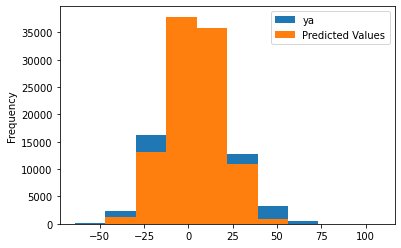

In [51]:
# Sequence 'ya'
linear_regression_model(X,ya)

Model's slope: [ 2.54470337e-01  3.23951987e-05 -2.25587058e-03  8.38307206e-04
  1.06717531e-04]
Model's y-intercept: 0.8414675908478901
Model's formula: y = 0.8414675908478901 + 0.2544703365666539X
The score is 0.8948694446521678.
The r2 is 0.8948694446521678.
The mean squared error is 0.06221899459398653.
The root mean squared error is 0.2494373560515476.
The standard deviation is 0.7693022722943236.


Predicted Values
count     100000.000000
mean           2.111733
std            0.727999
min            0.838143
25%            1.485165
50%            2.114480
75%            2.738725
max            3.381658

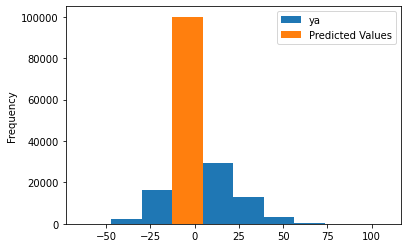

In [52]:
# Sequence 'yb'
linear_regression_model(X,yb)

Model's slope: [ 1.00380033e-04  3.80448816e-06 -1.26039179e-04  7.21007708e-05
 -2.89388687e-06]
Model's y-intercept: -0.00017419023826973395
Model's formula: y = -0.00017419023826973395 + 0.00010038003347271144X
The score is 4.504171936281498e-05.
The r2 is 4.504171936281498e-05.
The mean squared error is 0.0009741445254845837.
The root mean squared error is 0.031211288430383385.
The standard deviation is 0.031211991359176527.


Predicted Values
count     100000.000000
mean           0.000074
std            0.000181
min           -0.000597
25%           -0.000051
50%            0.000071
75%            0.000196
max            0.001252

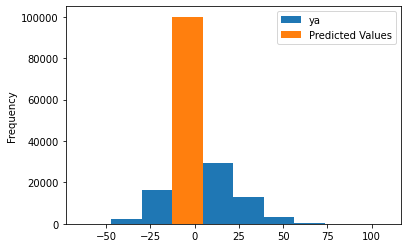

In [53]:
# Sequence 'yc'
linear_regression_model(X,yc)

**Question 1b.** Try to come up with a predictive model, e.g. y = f(x_1 , … , x_n) for each y sequence. Describe your models and how you came up with them. What (if any) are the predictive variables? How good would you say each of your models is?

**Answer:**

Considering that the question includes a formula of Linear Regression, and we want to predict the value of a variable based on the value of another variable, this is the model we will work with. A good indication of when to use a Linear Regression model is when the histograms look approximately normal. Although there are much more accurate models, a Linear Regression is highly interpretable as it describes the relationship between a dependent variable, y, and one or more independent variables, X. The dependent variable is also called the response variable. Independent variables are called predictor variables.

XGBoost will also be used as it is a scalable and highly accurate implementation of gradient boosting. It has both linear model solver and tree learning algorithms. So, what makes it fast is its capacity to do parallel computation on a single machine. It also has additional features for doing cross-validation and finding important variables which makes it essential to be used as a Feature Selection technique.

It is helpful to visualize the correlations to have a better understanding of the relationships within the dataset. This will show which variables are predictive by nature, a heatmap will be used to achieve this. After exploring the heatmaps, the following conclusions can be drawn:

-    yb is closely correlated to x1 and x3
-    ya has the most correlations, x1, x2, and x3, but less strong of a relationship
-    yc does not seem to be correlated to any of the feature sets

** *

** *

### 2. Consider data set 2 (ds2.csv). The dataset comprises a set of observations that correspond to multiple groups.

a. Describe the data in a few sentences

b. How would you visualize this data set?

c. Can you identify the number of groups in the data and assign each row to its group?

d. Can you create a good visualization of your groupings?

### Read in data

In [54]:
# Display the first few lines of 'ds2'
ds2_df.head()

X1         X2         X3         X4        X5         X6         X7  \
0  23.778224  13.319974  15.565124  -3.713626  7.296793 -19.371013  -0.894130   
1  16.602950  23.311281  21.099052  -0.304154 -3.218990   2.357643  12.027277   
2  12.084683  19.710443   9.837102  -1.081918 -1.201942   9.738019  16.125920   
3  13.044534  10.749040   5.884407 -11.703525 -4.134358 -22.344666  -1.263349   
4   8.314115   6.748794   5.388535  -0.000290 -4.724787 -16.346812   3.293600   

          X8         X9        X10  
0  -6.110282 -28.959316   2.851336  
1   7.070349  -5.762185 -23.050198  
2  19.119391 -15.582122 -12.292535  
3   0.493711 -15.305347   6.799087  
4 -10.848273 -17.285491   6.034214

### Clean Data

In [55]:
# Check the nulls
print("Null count for ds2")
display(ds2_df.isna().sum())

Null count for ds2


X1     0
X2     0
X3     0
X4     0
X5     0
X6     0
X7     0
X8     0
X9     0
X10    0
dtype: int64

### Statistical Summary of the Data

In [56]:
ds2_df.describe()

X1           X2           X3           X4           X5  \
count  2000.000000  2000.000000  2000.000000  2000.000000  2000.000000   
mean      8.677829    11.716801     9.252817    -2.679634     2.774942   
std      11.971827     6.655333     9.861443    10.625164     8.800553   
min     -25.824199    -8.497562   -23.666439   -29.429655   -22.033329   
25%       0.231327     7.161564     2.648845   -10.652694    -4.098043   
50%      12.754335    11.896021    11.422441    -2.631318     2.484416   
75%      17.364337    16.279210    16.503676     5.340314     9.660898   
max      32.268570    32.909917    31.230550    26.422798    29.312010   

                X6           X7           X8           X9          X10  
count  2000.000000  2000.000000  2000.000000  2000.000000  2000.000000  
mean      0.077631     8.200884     8.712878   -12.860135    -1.339360  
std      15.375478    10.426023     9.881482     8.881026    14.534143  
min     -35.264019   -21.428538   -16.811146   -36.065150   -36.468083  
25%     -14.003670    -0.812888     1.480706   -19.430697   -13.216190  
50%       1.500838     8.532535     9.628064   -14.417786    -2.094310  
75%      14.050512    17.138898    16.081044    -6.534142    10.561797  
max      31.727042    32.084297    36.847922    13.553705    32.641789

### Vsualize the data

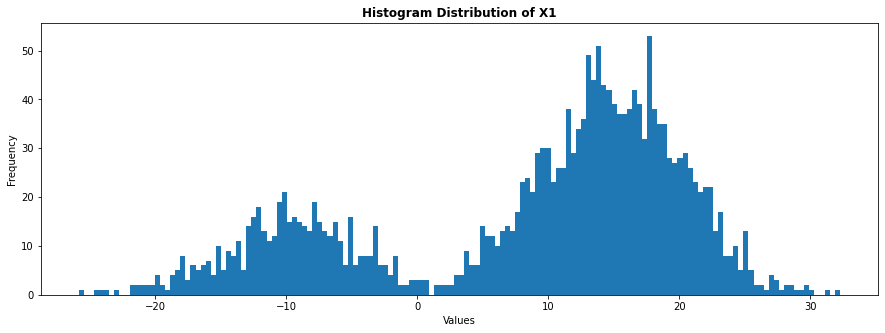

Fitting 10 distributions: 100%|██████████| 10/10 [00:01<00:00,  8.95it/s]


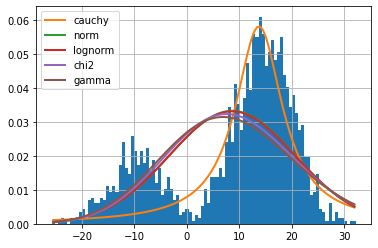

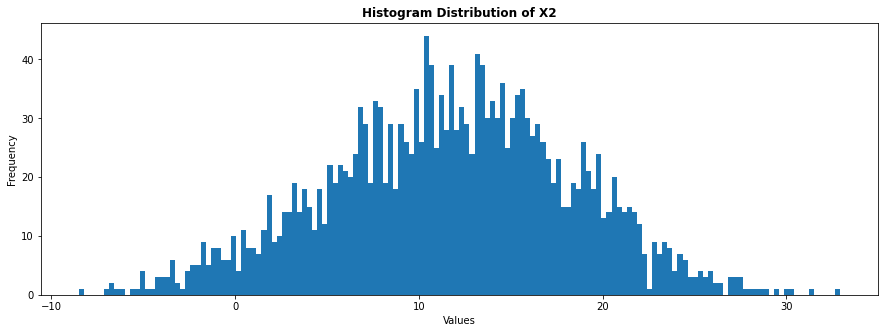

Fitting 10 distributions: 100%|██████████| 10/10 [00:00<00:00, 10.38it/s]


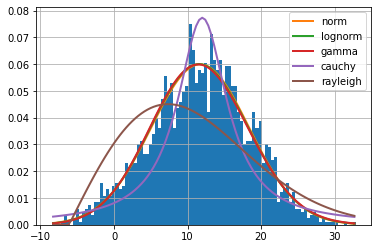

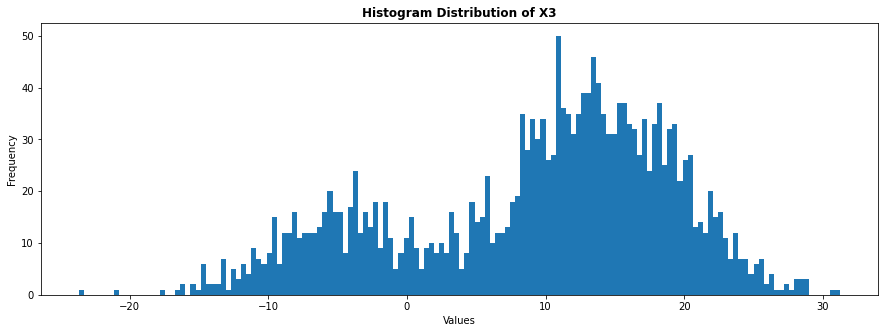

Fitting 10 distributions: 100%|██████████| 10/10 [00:01<00:00,  7.47it/s]


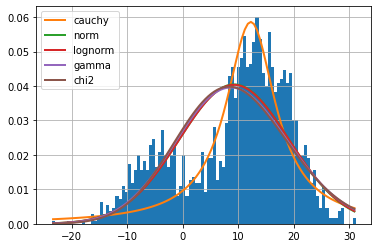

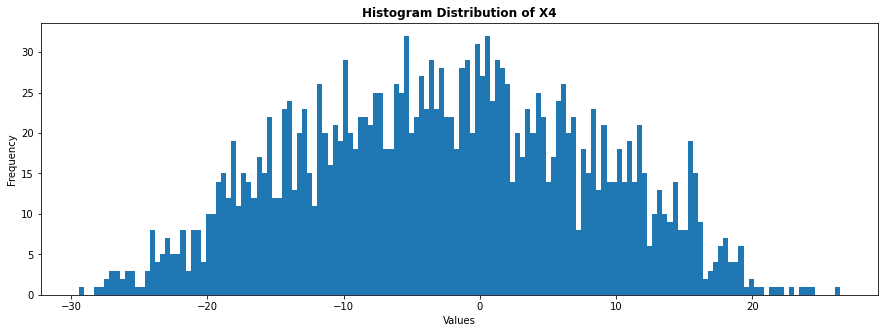

Fitting 10 distributions: 100%|██████████| 10/10 [00:01<00:00,  9.21it/s]


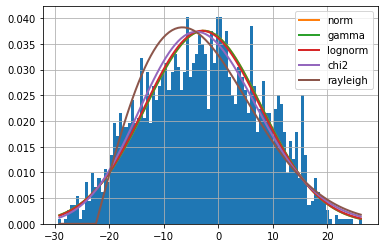

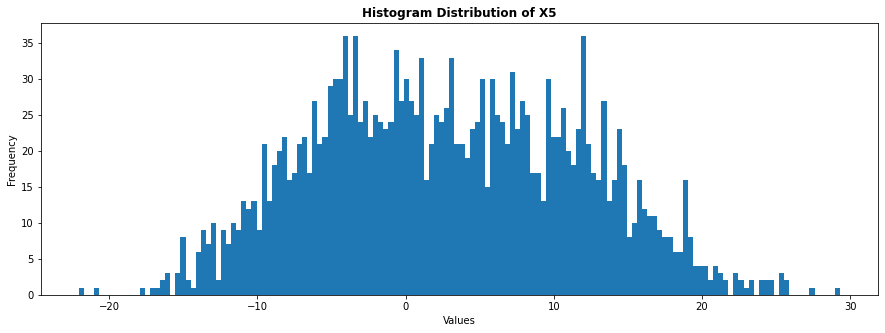

Fitting 10 distributions: 100%|██████████| 10/10 [00:01<00:00,  9.93it/s]


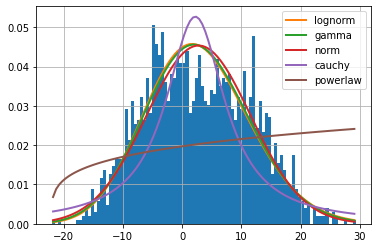

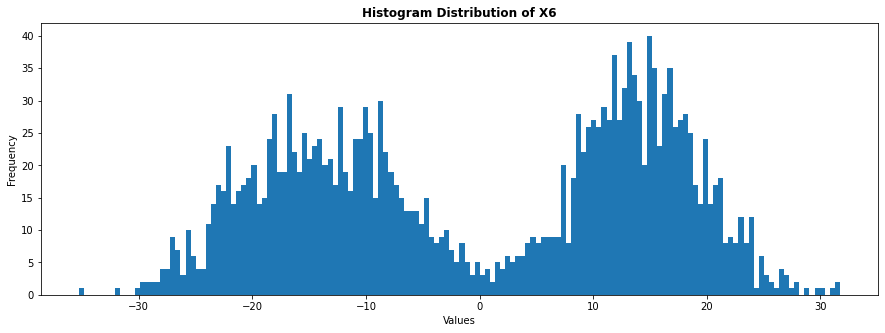

Fitting 10 distributions: 100%|██████████| 10/10 [00:01<00:00,  9.05it/s]


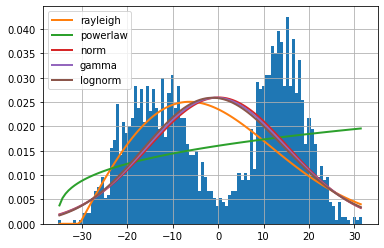

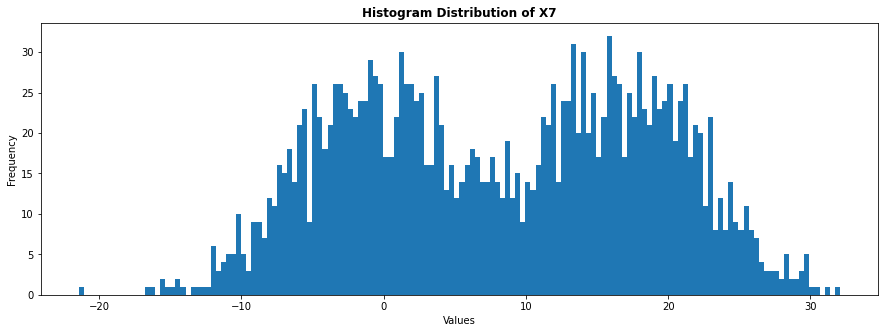

Fitting 10 distributions: 100%|██████████| 10/10 [00:01<00:00,  7.78it/s]


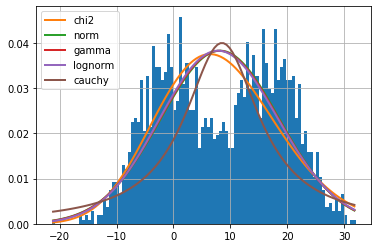

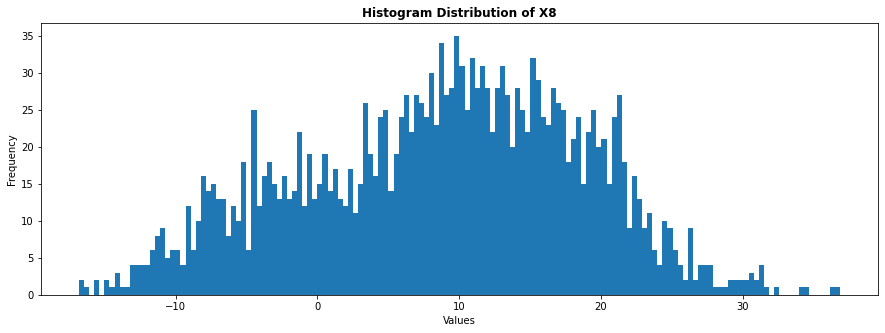

Fitting 10 distributions: 100%|██████████| 10/10 [00:01<00:00,  8.16it/s]


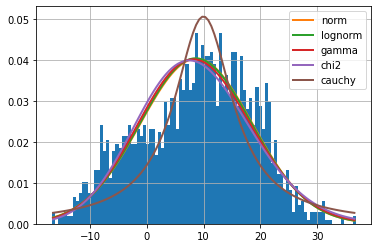

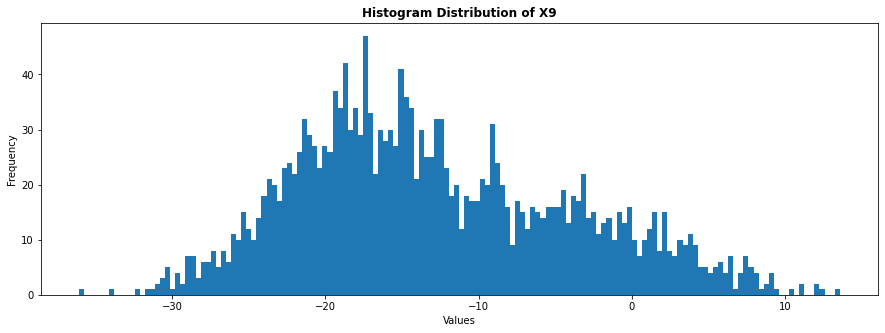

Fitting 10 distributions: 100%|██████████| 10/10 [00:01<00:00,  9.99it/s]


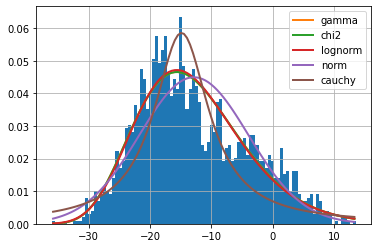

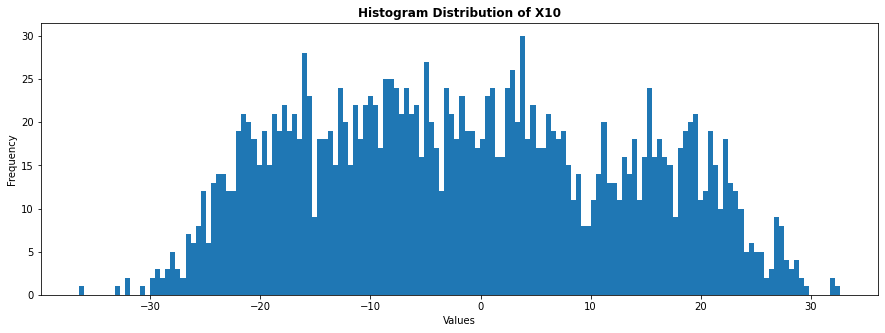

Fitting 10 distributions: 100%|██████████| 10/10 [00:01<00:00,  8.37it/s]


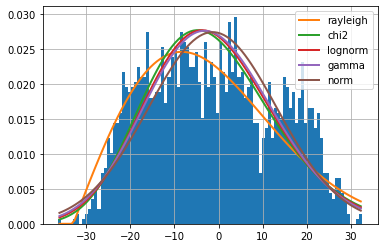

In [57]:
for feature in ds2_df:
    OptimalHistogramDistribution(ds2_df, feature)

### Identify the number of groups in the data

### Use the elbow method to determine the optimal number of clusters (groups), k, in the 'ds2' dataset.
### Once the elbow curve has been established, evaluate the two most likely values for k using the K-means algorithm and a scatter plot.

In [58]:
# Scale the data by using the StandardScaler() module to normalize the DataFrame values.
standard_scaler = StandardScaler().fit_transform(ds2_df)

In [59]:
# Create a DataFrame with the scaled data.
# Use the columns and index DataFrame's attributes to set the features and the index of the new DataFrame.
scaled_df = pd.DataFrame(ds2_df, columns = ds2_df.columns, index = ds2_df.index)

# Show sample data
scaled_df.head()

X1         X2         X3         X4        X5         X6         X7  \
0  23.778224  13.319974  15.565124  -3.713626  7.296793 -19.371013  -0.894130   
1  16.602950  23.311281  21.099052  -0.304154 -3.218990   2.357643  12.027277   
2  12.084683  19.710443   9.837102  -1.081918 -1.201942   9.738019  16.125920   
3  13.044534  10.749040   5.884407 -11.703525 -4.134358 -22.344666  -1.263349   
4   8.314115   6.748794   5.388535  -0.000290 -4.724787 -16.346812   3.293600   

          X8         X9        X10  
0  -6.110282 -28.959316   2.851336  
1   7.070349  -5.762185 -23.050198  
2  19.119391 -15.582122 -12.292535  
3   0.493711 -15.305347   6.799087  
4 -10.848273 -17.285491   6.034214

In [60]:
# Create two lists: one to hold the list of inertia scores and another for the range of k values (from 1 to 11) to analyze.

# Create a list to store inertia values
inertia = []

# Create a list to store the values of k
k = list(range(1, 11))

### Use a for-loop to evaluate each instance of k, 
### define a K-means model, 
### fit the K-means model based on the scaled DataFrame, 
### and append the model’s inertia to the empty inertia list created in the previous step.

In [61]:
# Create a for-loop where each value of k is evaluated using the K-means algorithm
# Fit the model using the 'scaled_df' DataFrame
# Append the value of the computed inertia from the `inertia_` attribute of the KMeans model instance
for i in k:
    k_model = KMeans(n_clusters=i, random_state=1)
    k_model.fit(scaled_df)
    inertia.append(k_model.inertia_)

In [62]:
# Store the values for k and the inertia in a Dictionary called elbow_data. Use elbow_data to create a Pandas DataFrame called df_elbow.

# Create a Dictionary that holds the list values for k and inertia
elbow_data = {"k": k, "inertia": inertia}

# Create a DataFrame using the elbow_data Dictionary
df_elbow = pd.DataFrame(elbow_data)

# Review the DataFrame
df_elbow.head()

k       inertia
0  1  2.414942e+06
1  2  1.163652e+06
2  3  7.524288e+05
3  4  5.010931e+05
4  5  4.902783e+05

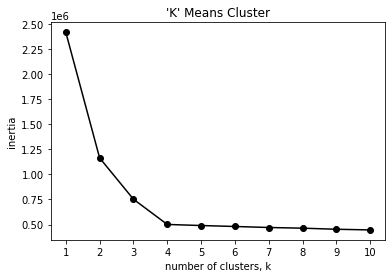

In [63]:
plt.plot(k, inertia, '-o', color='black')
plt.title("'K' Means Cluster")
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(k)
plt.show()

# Save fig to Images folder
# plt.savefig('./Images/KmeansCluster.png')

In [64]:
# Perform the following tasks for each of the two most likely values of k:
# Define a K-means model using k to define the clusters, fit the model, make predictions,
# add the prediction values to a copy of the scaled DataFrame and call it predictions_df.

# Define the model with the lower value of k clusters
# Use a random_state of 1 to generate the model
model = KMeans(n_clusters=4, random_state=1)

# Fit the model
model.fit(scaled_df)

# Make predictions
k_lower = model.predict(scaled_df)

# Create a copy of the DataFrame and name it as predictions_df
predictions_df = scaled_df.copy()

# Add a class column with the labels to the predictions_df DataFrame
predictions_df['Clusters Predictions'] = k_lower

# Save the DataFrame to the `Resources` folder
predictions_df.to_csv("./Resources/predictions_df.csv")

predictions_df.head()

X1         X2         X3         X4        X5         X6         X7  \
0  23.778224  13.319974  15.565124  -3.713626  7.296793 -19.371013  -0.894130   
1  16.602950  23.311281  21.099052  -0.304154 -3.218990   2.357643  12.027277   
2  12.084683  19.710443   9.837102  -1.081918 -1.201942   9.738019  16.125920   
3  13.044534  10.749040   5.884407 -11.703525 -4.134358 -22.344666  -1.263349   
4   8.314115   6.748794   5.388535  -0.000290 -4.724787 -16.346812   3.293600   

          X8         X9        X10  Clusters Predictions  
0  -6.110282 -28.959316   2.851336                     0  
1   7.070349  -5.762185 -23.050198                     2  
2  19.119391 -15.582122 -12.292535                     2  
3   0.493711 -15.305347   6.799087                     0  
4 -10.848273 -17.285491   6.034214                     0

In [65]:
# Plot the clusters
scaled_df.hvplot.scatter(
    by="clusters_lower"
).opts(yformatter="%.0f")

# Save fig to Images folder
# plt.savefig('./Images/ScatterCluster.png')

:NdOverlay   [Variable]
   :Scatter   [index]   (value)

In [66]:
# Instantiate the PCA instance and declare the number of PCA variables as 4
pca = PCA(n_components=4)

In [67]:
# Use the fit_transform() function from PCA, fit the PCA model to the scaled_df DataFrame. 
# Review the first 5 rows of list data.

# Fit the PCA model on the transformed scaled_df DataFrame
customers_pca = pca.fit_transform(scaled_df)

# Review the first 5 rows of the array of list data
customers_pca[:5]

array([[-29.52854407,  10.18256067,   4.19215298,   0.19606901],
       [ 10.76236905,  23.60014195,  -2.6002326 ,   1.9817502 ],
       [ 15.13478154,   9.41612857,  -7.1524435 ,   1.49881417],
       [-24.99839736,   0.48644497,  13.88760661,  -1.99266653],
       [-18.60463438,   2.86849795,  20.03648266,  -0.96109   ]])

### Using the explained_variance_ratio_ function from PCA, calculate the percentage of the total variance that is captured by the four PCA variables.

In [68]:
# Calculate the PCA explained variance ratio
pca.explained_variance_ratio_

array([0.5678694 , 0.19094371, 0.09618806, 0.02410115])

**Question:** What is the explained variance ratio captured by the four PCA variables?


**Answer:** About 87% of the total variance is condensed into the 4 PCA variables.

### Use the PCA data, create a Pandas DataFrame called pca_df. 
### The columns of the DataFrame should be called "PCA1", "PCA2", "PCA3" & "PCA4"

In [69]:
# Create the PCA DataFrame
pca_df = pd.DataFrame(customers_pca, columns=["PCA1", "PCA2", "PCA3", "PCA4"])


# Save the DataFrame to the `Resources` folder
pca_df.to_csv("./Resources/pca.csv")

# Review the PCA DataFrame
pca_df.head()

PCA1       PCA2       PCA3      PCA4
0 -29.528544  10.182561   4.192153  0.196069
1  10.762369  23.600142  -2.600233  1.981750
2  15.134782   9.416129  -7.152443  1.498814
3 -24.998397   0.486445  13.887607 -1.992667
4 -18.604634   2.868498  20.036483 -0.961090

### Create the scatterplot to visualize the PCA  

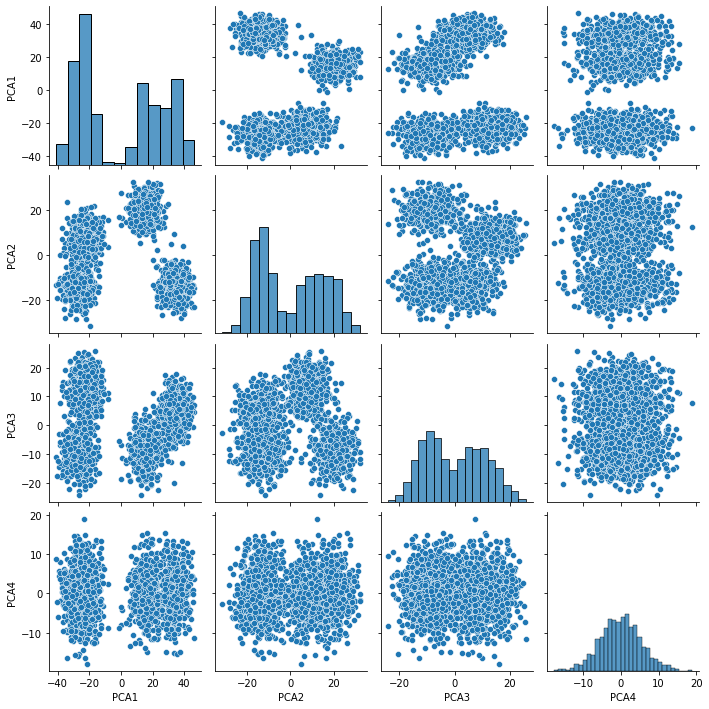

In [70]:
# Create a seaborn scatterplot matrix to show the correlation, 
# save the figure to the Images folder

sns.pairplot(pca_df, height = 2.5, diag_kind='auto')
plt.savefig('./Images/scaled_ds2_pair_plot.png',dpi=150, bbox_inches='tight')

<class 'matplotlib.axes._subplots.AxesSubplot'>


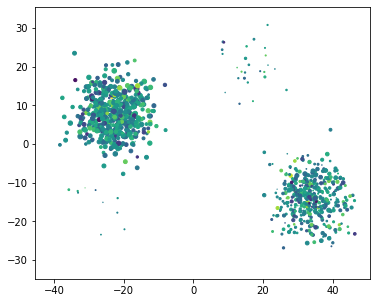

In [71]:
# Create another visualization to depict the relationship of the groupings
plt.figure(figsize=(6,5))
axes = plt.axes()
print(type(axes))
axes.scatter(pca_df.PCA1, pca_df.PCA2, pca_df.PCA3, pca_df.PCA4)
plt.show();
# plt.savefig('./Images/pca_scatter.png',dpi=300, bbox_inches='tight')

In [72]:
# Plot the clusters
pca_df.hvplot.scatter(
    by="clusters_lower"
).opts(yformatter="%.0f")

# plt.savefig('./Images/pca_cluster.png',dpi=300, bbox_inches='tight')

:NdOverlay   [Variable]
   :Scatter   [index]   (value)

** *

** *

### Stack Overflow provides a tool at https://data.stackexchange.com/stackoverflow/query/new that allows SQL queries to be run against their data. After reviewing the database schema provided on their site, please answer the questions below by providing both your answer and the query used to derive it.

a. How many posts were created in 2017?

b. What post/question received the most answers?

c. For posts created in 2020, what were the top 10 tags?

d. *BONUS* For the questions created in 2017, what was the average time (in seconds) between when the question was created and when the accepted answer was provided?

-- 3a. How many posts were created in 2017?

    SELECT 
    count(Id) AS PostsCreated2017
    FROM Posts
    WHERE year(CreationDate) = '2017';

-- 3b. What post/question received the most answers?

    SELECT Top 1
    Id, Title, AnswerCount
    from Posts
    order by AnswerCount desc;

-- 3c. For posts created in 2020, what were the top 10 tags?


    SELECT Top 10
    Tags, count(Id) AS Quantity
    from Posts
    where DATEPART(year, CreationDate)=2020
    and Tags is not null
    group by Tags
    ORDER BY count(Id) DESC;

In [73]:
path1 = Path('./SQL/Resources/PostsCreated2017.csv')
a = pd.read_csv(path1)
print('How many posts were created in 2017?')
display(a)
print()

path2 = Path('./SQL/Resources/TopPost.csv')
b = pd.read_csv(path2)
print('What post/question received the most answers?')
display(b)
print()

path3 = Path('./SQL/Resources/Top10Tags.csv')
c = pd.read_csv(path3)
print('For posts created in 2020, what were the top 10 tags?')
display(c)

How many posts were created in 2017?


PostsCreated2017
0           5026721


What post/question received the most answers?


Id                                              Title  AnswerCount
0  184618  What is the best comment in source code you ha...          518


For posts created in 2020, what were the top 10 tags?


Tags  Quantity
0               <python>     16256
1           <javascript>     12864
2       <python><pandas>      9684
3                    <r>      8832
4            <html><css>      7762
5                 <java>      7061
6           <excel><vba>      6809
7  <javascript><reactjs>      6727
8                  <c++>      6634
9              <reactjs>      5475